In [0]:
!pip install tabulate

In [0]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from google.colab import drive
import csv
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [0]:
drive.mount('/Downloads/')

Drive already mounted at /Downloads/; to attempt to forcibly remount, call drive.mount("/Downloads/", force_remount=True).


In [0]:
#first lets import the original data

original = pd.read_csv('Original_data.csv')

In [0]:
#observe the heatmap to check the NaN value in the orginal dataset

original.shape
#heatmap will kill the kernel on Colab
#sns.heatmap(original.isnull(),yticklabels=False,cmap='viridis')

(8013713, 21)

In [0]:
train = pd.read_csv('train_no_missing_outlier.csv')
test = pd.read_csv('test_no_missing_outlier.csv')

train.drop(['id','open_date', 'caller_sum_45', 'caller_sum_456',
                              'record_sum_45', 'record_sum_456', 'time_sum_45', 'time_sum_456'], axis = 1, inplace=True)
# test.drop(['id','open_date', 'caller_sum_45', 'caller_sum_456',
#                               'record_sum_45', 'record_sum_456', 'time_sum_45', 'time_sum_456'], axis = 1, inplace=True)

In [0]:
#check if train dataframe contains any NaN values
train.isnull().values.any()

False

In [0]:
train.shape

(5090258, 13)

In [0]:
train.head()

,caller_sum_6,record_sum_6,time_sum_6,caller_sum_4,record_sum_4,time_sum_4,caller_sum_5,record_sum_5,time_sum_5,brand,city_flag,day,flag
0,198,535,2295,197,572,2666,224,638,2678,1,1,863,0
1,8,8,14,68,147,495,1,1,1,1,1,1809,1
2,26,74,291,25,100,403,29,87,340,2,1,2551,0
3,49,213,797,50,210,771,56,245,1026,3,1,91,0
4,229,726,2628,212,726,2498,236,766,2723,1,0,2121,0


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090258 entries, 0 to 5090257
Data columns (total 13 columns):
caller_sum_6    int64
record_sum_6    int64
time_sum_6      int64
caller_sum_4    int64
record_sum_4    int64
time_sum_4      int64
caller_sum_5    int64
record_sum_5    int64
time_sum_5      int64
brand           int64
city_flag       int64
day             int64
flag            int64
dtypes: int64(13)
memory usage: 504.9 MB


In [0]:
#remove scientific notation for easier reading
pd.options.display.float_format = '{:.2f}'.format

train.describe()

,caller_sum_6,record_sum_6,time_sum_6,caller_sum_4,record_sum_4,time_sum_4,caller_sum_5,record_sum_5,time_sum_5,brand,city_flag,day,flag
count,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00,5090258.00
mean,30.86,92.33,405.75,30.19,97.29,430.66,32.30,98.11,432.84,2.21,0.63,1455.86,0.14
std,35.78,97.32,455.96,36.48,103.72,491.77,38.07,103.36,489.01,0.65,0.48,1253.51,0.35
min,1.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,-1.00,61.00,0.00
25%,11.00,32.00,107.00,11.00,33.00,109.00,12.00,33.00,112.00,2.00,0.00,358.00,0.00
50%,21.00,66.00,262.00,21.00,69.00,273.00,22.00,70.00,278.00,2.00,1.00,1125.00,0.00
75%,38.00,119.00,540.00,37.00,125.00,574.00,40.00,126.00,577.00,3.00,1.00,2292.00,0.00
max,6676.00,7083.00,30375.00,8350.00,9947.00,21712.00,9001.00,9208.00,29832.00,3.00,1.00,8946.00,1.00


In [0]:
# sns.heatmap(train.isnull(),yticklabels=False,cmap='viridis')

In [0]:
#here are all the features in training set
train.columns

Index([u'caller_sum_6', u'record_sum_6', u'time_sum_6', u'caller_sum_4',
       u'record_sum_4', u'time_sum_4', u'caller_sum_5', u'record_sum_5',
       u'time_sum_5', u'brand', u'city_flag', u'day', u'flag'],
      dtype='object')

In [0]:
df1 = pd.DataFrame(train[train['flag']==1][['caller_sum_4','caller_sum_5','caller_sum_6']])
df0 = pd.DataFrame(train[train['flag']==0][['caller_sum_4','caller_sum_5','caller_sum_6']])

grouped_df1 = df1.apply(pd.Series.value_counts)
grouped_df0 = df0.apply(pd.Series.value_counts)

new_col1 = grouped_df1.index
new_col0 = grouped_df0.index

grouped_df1['indices'] = new_col1
grouped_df0['indices'] = new_col0

# grouped_df1.groupby(pd.cut(grouped_df1['indices'], np.arange(0,100,10))).sum()
# grouped_df0.groupby(pd.cut(grouped_df0['indices'], np.arange(0,100,10))).sum()

#group all caller_sum higher than 100

limit = 100
increment = 10

more_df1 = grouped_df1[grouped_df1['indices']>=limit].sum(axis = 0)
more_df0 = grouped_df0[grouped_df0['indices']>=limit].sum(axis = 0)

updated_df1 = grouped_df1[grouped_df1['indices']<limit]
updated_df0 = grouped_df0[grouped_df0['indices']<limit]

new_ind = updated_df0.shape[0] + 1

updated_df1.loc[new_ind]=more_df1.tolist()
updated_df0.loc[new_ind]=more_df0.tolist()

updated_df1.loc[new_ind,'indices'] = limit + 1
updated_df0.loc[new_ind,'indices'] = limit + 1

final_df1 = updated_df1.groupby(pd.cut(updated_df1['indices'], np.arange(0,limit + increment + 1,increment))).sum()
final_df0 = updated_df0.groupby(pd.cut(updated_df0['indices'], np.arange(0,limit + increment + 1,increment))).sum()

#now convert to percentage

total0 = grouped_df0.sum(axis=0).tolist()[0]
total1 = grouped_df1.sum(axis=0).tolist()[0]

final_df0 = final_df0.divide(total0)
final_df1 = final_df1.divide(total1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be s

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


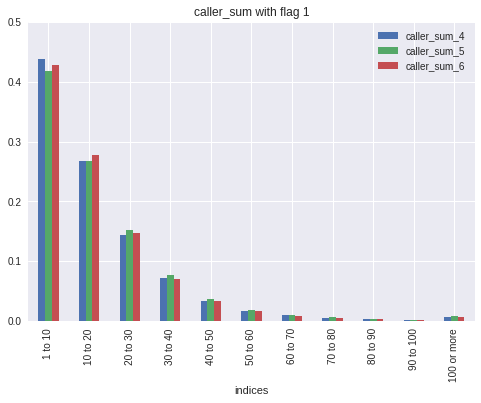

In [0]:
ax1 = final_df1.plot( y = ['caller_sum_4','caller_sum_5', 'caller_sum_6'], kind = 'bar', title = 'caller_sum with flag 1')

ax1.set_xticklabels(['1 to 10', '10 to 20', '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80', '80 to 90', 
                    '90 to 100', '100 or more'])

ylim = ax1.set_ylim(0,0.5)

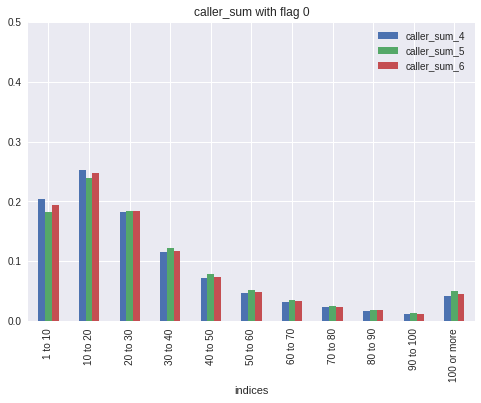

In [0]:
ax0 = final_df0.plot( y = ['caller_sum_4','caller_sum_5', 'caller_sum_6'], kind = 'bar', title="caller_sum with flag 0")

ax0.set_xticklabels(['1 to 10', '10 to 20', '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80', '80 to 90', 
                    '90 to 100', '100 or more'])

ylim = ax0.set_ylim(0,0.5)

In [0]:
#now vizualize record_sum, wich is the number of phone calls made in a given month

df1 = pd.DataFrame(train[train['flag']==1][['record_sum_4','record_sum_5','record_sum_6']])
df0 = pd.DataFrame(train[train['flag']==0][['record_sum_4','record_sum_5','record_sum_6']])

grouped_df1 = df1.apply(pd.Series.value_counts)
grouped_df0 = df0.apply(pd.Series.value_counts)

new_col1 = grouped_df1.index
new_col0 = grouped_df0.index

grouped_df1['indices'] = new_col1
grouped_df0['indices'] = new_col0

# grouped_df1.groupby(pd.cut(grouped_df1['indices'], np.arange(0,200,20))).sum()
# grouped_df0.groupby(pd.cut(grouped_df0['indices'], np.arange(0,300,30))).sum()

#group all record_sum higher than 500

limit = 200
increment = 20

more_df1 = grouped_df1[grouped_df1['indices']>=limit].sum(axis = 0)
more_df0 = grouped_df0[grouped_df0['indices']>=limit].sum(axis = 0)

updated_df1 = grouped_df1[grouped_df1['indices']<limit]
updated_df0 = grouped_df0[grouped_df0['indices']<limit]

new_ind = updated_df0.shape[0] + 1

updated_df1.loc[new_ind]=more_df1.tolist()
updated_df0.loc[new_ind]=more_df0.tolist()

updated_df1.loc[new_ind,'indices'] = limit+1
updated_df0.loc[new_ind,'indices'] = limit+1

final_df1 = updated_df1.groupby(pd.cut(updated_df1['indices'], np.arange(0,limit + increment + 1,increment))).sum()
final_df0 = updated_df0.groupby(pd.cut(updated_df0['indices'], np.arange(0,limit + increment + 1,increment))).sum()

#now convert to percentage

total0 = grouped_df0.sum(axis=0).tolist()[0]
total1 = grouped_df1.sum(axis=0).tolist()[0]

final_df0 = final_df0.divide(total0)
final_df1 = final_df1.divide(total1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

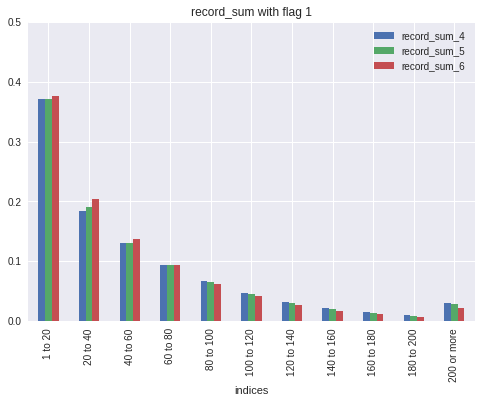

In [0]:
ax1 = final_df1.plot( y = ['record_sum_4','record_sum_5', 'record_sum_6'], kind = 'bar', title="record_sum with flag 1")

ax1.set_xticklabels(['1 to 20', '20 to 40', '40 to 60', '60 to 80', '80 to 100', '100 to 120', '120 to 140', '140 to 160', '160 to 180', 
                    '180 to 200', '200 or more'])

ylim = ax1.set_ylim(0,0.5)

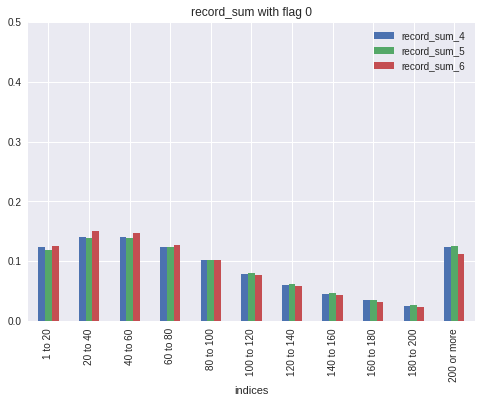

In [0]:
ax0 = final_df0.plot( y = ['record_sum_4','record_sum_5', 'record_sum_6'], kind = 'bar', title="record_sum with flag 0")

ax0.set_xticklabels(['1 to 20', '20 to 40', '40 to 60', '60 to 80', '80 to 100', '100 to 120', '120 to 140', '140 to 160', '160 to 180', 
                    '180 to 200', '200 or more'])
ylim = ax0.set_ylim(0,0.5)

In [0]:
#now timer_sum, which is how much time spent on each call for a given month

df1 = pd.DataFrame(train[train['flag']==1][['time_sum_4','time_sum_5','time_sum_6']])
df0 = pd.DataFrame(train[train['flag']==0][['time_sum_4','time_sum_5','time_sum_6']])

grouped_df1 = df1.apply(pd.Series.value_counts)
grouped_df0 = df0.apply(pd.Series.value_counts)

new_col1 = grouped_df1.index
new_col0 = grouped_df0.index

grouped_df1['indices'] = new_col1
grouped_df0['indices'] = new_col0

# grouped_df1.groupby(pd.cut(grouped_df1['indices'], np.arange(0,1000,100))).sum()
# grouped_df0.groupby(pd.cut(grouped_df0['indices'], np.arange(0,5000,500))).sum()

#group all timer_sum higher than 1000

limit = 1000
increment = 100

more_df1 = grouped_df1[grouped_df1['indices']>=limit].sum(axis = 0)
more_df0 = grouped_df0[grouped_df0['indices']>=limit].sum(axis = 0)

updated_df1 = grouped_df1[grouped_df1['indices']<limit]
updated_df0 = grouped_df0[grouped_df0['indices']<limit]

new_ind = updated_df0.shape[0] + 1

updated_df1.loc[new_ind]=more_df1.tolist()
updated_df0.loc[new_ind]=more_df0.tolist()

updated_df1.loc[new_ind,'indices'] = limit + 1
updated_df0.loc[new_ind,'indices'] = limit + 1

final_df1 = updated_df1.groupby(pd.cut(updated_df1['indices'], np.arange(0,limit + increment + 1,increment))).sum()
final_df0 = updated_df0.groupby(pd.cut(updated_df0['indices'], np.arange(0,limit + increment + 1,increment))).sum()

#now convert to percentage

total0 = grouped_df0.sum(axis=0).tolist()[0]
total1 = grouped_df1.sum(axis=0).tolist()[0]

final_df0 = final_df0.divide(total0)
final_df1 = final_df1.divide(total1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

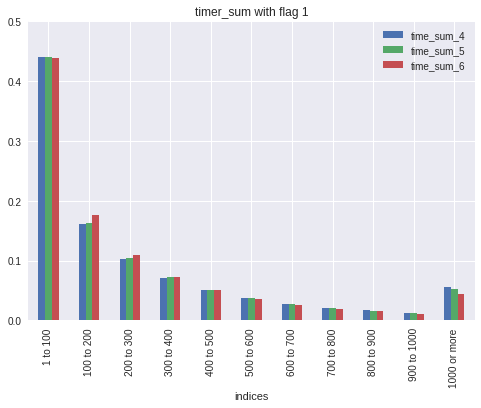

In [0]:
ax1 = final_df1.plot( y = ['time_sum_4','time_sum_5','time_sum_6'], kind = 'bar', title="timer_sum with flag 1")

ax1.set_xticklabels(['1 to 100', '100 to 200', '200 to 300', '300 to 400', '400 to 500', '500 to 600', '600 to 700', '700 to 800', '800 to 900', 
                    '900 to 1000', '1000 or more'])

ylim = ax1.set_ylim(0,0.5)

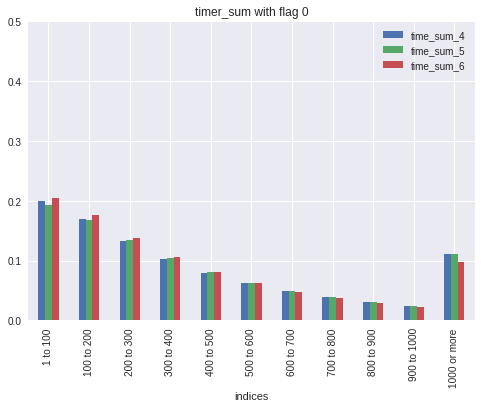

In [0]:
ax0 = final_df0.plot( y = ['time_sum_4','time_sum_5','time_sum_6'], kind = 'bar', title="timer_sum with flag 0")

ax0.set_xticklabels(['1 to 100', '100 to 200', '200 to 300', '300 to 400', '400 to 500', '500 to 600', '600 to 700', '700 to 800', '800 to 900', 
                    '900 to 1000', '1000 or more'])

ylim = ax0.set_ylim(0,0.5)

In [0]:
#now lets do data analysis
train = train.values

In [0]:
# pca = PCA(n_components=10)
# pca_train = pca.fit_transform(train[:,0:18])
pca_train = np.delete(train,-1,1)

train_y = train[:,-1]
train_y = train_y.astype(float)

train_x = pca_train
train_x = train_x.astype(float)

#balance data by over_sampling using SMOTE(Synthetic Minority Oversampling Technique)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0)


#scale (MUST scale to make it work)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [0]:
#try different weight for class 0 and 1
num_matrix = 5

confusion_matrix_list = np.zeros((num_matrix, 4, 2)) 
# +2 for including the corresponding weight assignment and accuracy

roc_list = np.zeros(num_matrix)

weight1 = 0.1
weight2 = 0.9

for i in range(num_matrix):
  log_reg = LogisticRegression(class_weight = {0:weight1, 1:weight2}, random_state=42)
  log_reg.fit(X_train, y_train)
  y_pred = log_reg.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)

  confusion_matrix_list[i][0:-2] = conf_matrix
  confusion_matrix_list[i][-2] = np.array([weight1, weight2])
  roc_score = roc_auc_score(y_test, log_reg.predict(X_test))
  confusion_matrix_list[i][-1] = np.array([log_reg.score(X_test, y_test), roc_score])
  roc_list[i] = roc_score

  weight1 += 0.1
  weight2 -= 0.1
  

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
from tabulate import tabulate

print tabulate(confusion_matrix_list, headers=['True Negative/False Negative','False Positive/True Positive', 'class 0 weight/class 1 weight', 'test accuracy/ ROC score'])

True Negative/False Negative    False Positive/True Positive    class 0 weight/class 1 weight    test accuracy/ ROC score
------------------------------  ------------------------------  -------------------------------  --------------------------
[481831. 391000.]               [ 19151. 126070.]               [0.1 0.9]                        [0.59712176 0.71007877]
[674193. 198638.]               [ 45040. 100181.]               [0.2 0.8]                        [0.76064287 0.73113651]
[788079.  84752.]               [72917. 72304.]                 [0.3 0.7]                        [0.84512677 0.70039465]
[845912.  26919.]               [105690.  39531.]               [0.4 0.6]                        [0.86974241 0.62068584]
[868381.   4450.]               [133094.  12127.]               [0.5 0.5]                        [0.86489492 0.53920443]
